In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)

tf.set_random_seed(777)

1.9.0


In [2]:
learning_rate = 0.001
training_epochs = 20
batch_size = 100

In [3]:
mnist = keras.datasets.mnist
class_names = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
#mnist = keras.datasets.fashion_mnist
#class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

In [4]:
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

In [5]:
type(train_images), type(train_labels)

(numpy.ndarray, numpy.ndarray)

In [6]:
train_images.shape, train_labels.shape

((60000, 28, 28), (60000,))

In [7]:
test_images.shape, test_labels.shape

((10000, 28, 28), (10000,))

In [8]:
train_images.dtype, train_labels.dtype

(dtype('uint8'), dtype('uint8'))

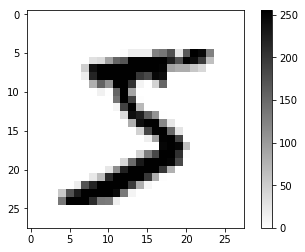

In [9]:
plt.figure()
plt.imshow(train_images[0], cmap=plt.cm.binary)
plt.colorbar()

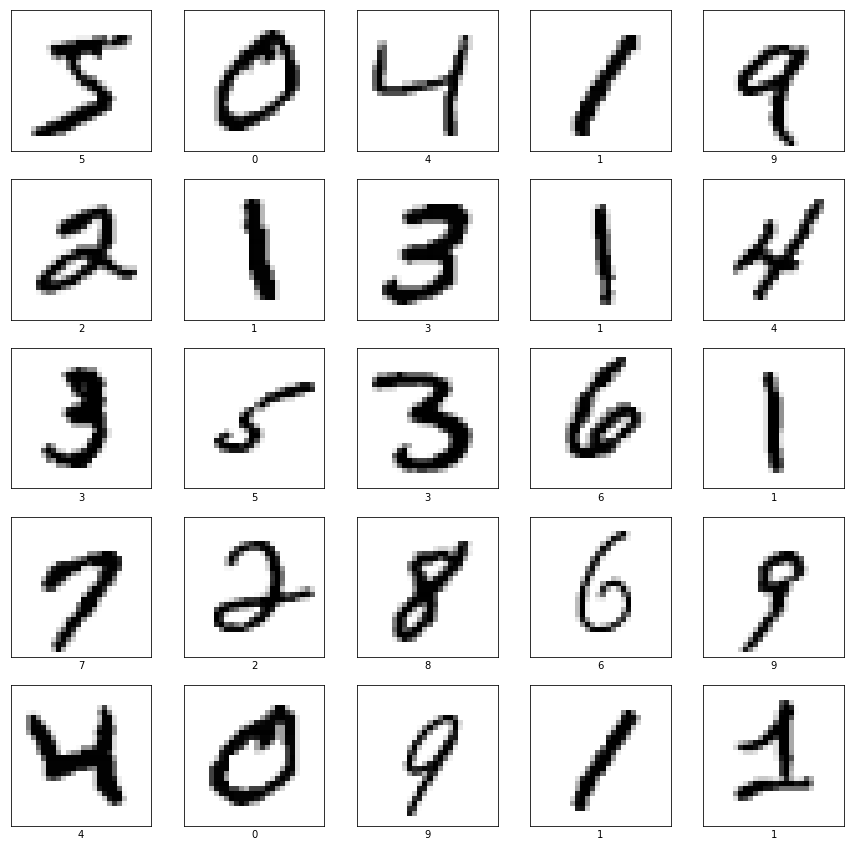

In [10]:
plt.figure(figsize=(15,15))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i]])

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels)).shuffle(
    buffer_size=100000).prefetch(buffer_size=batch_size).batch(batch_size).repeat()
test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels)).shuffle(
    buffer_size=100000).prefetch(buffer_size=batch_size).batch(batch_size).repeat()

In [ ]:
train_dataset.output_types

In [ ]:
train_dataset.output_shapes

In [ ]:
iterator = tf.data.Iterator.from_structure(train_dataset.output_types, train_dataset.output_shapes)
images, labels = iterator.get_next()

In [ ]:
train_init = iterator.make_initializer(train_dataset)
test_init = iterator.make_initializer(test_dataset)

In [ ]:
vec_images = tf.reshape(images, [-1, 784])
vec_images = tf.cast(vec_images, tf.float32) / 255.
onehot_labels = tf.one_hot(labels, 10)

In [ ]:
W = tf.get_variable(name='W', shape=(784, 10), initializer=tf.random_normal_initializer(0, 0.01))
b = tf.get_variable(name='b', shape=(10,), initializer=tf.random_normal_initializer(0, 0.01))

In [ ]:
hypothesis = tf.matmul(vec_images, W) + b

In [ ]:
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(
    logits=hypothesis, labels=onehot_labels))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

In [ ]:
correct_prediction = tf.equal(tf.argmax(hypothesis, 1), tf.argmax(onehot_labels, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [ ]:
sess = tf.Session(config=tf.ConfigProto(gpu_options=tf.GPUOptions(allow_growth =True)))
sess.run(tf.global_variables_initializer())

In [ ]:
# train my model
print('Learning started. It takes sometime.')
max_test_acc = 0.
for epoch in range(training_epochs):
    avg_cost = 0.
    avg_train_acc = 0.
    avg_test_acc = 0.
    
    total_batch = int(train_images.shape[0] / batch_size)
    total_batch_test = int(test_images.shape[0] / batch_size)
    
    sess.run(train_init)
    for i in range(total_batch):
        acc, c, _ = sess.run([accuracy, cost, optimizer])
        avg_cost += c / total_batch
        avg_train_acc += acc / total_batch
        
    sess.run(test_init)        
    for i in range(total_batch_test):
        acc = sess.run(accuracy)
        avg_test_acc += acc / total_batch_test

    print('Epoch:', '{}'.format(epoch + 1), 'cost =', '{:.8f}'.format(avg_cost), 
          'train accuracy = ', '{:.4f}'.format(avg_train_acc), 
          'test accuracy = ', '{:.4f}'.format(avg_test_acc))


print('Learning Finished!')

In [ ]:
def plot_image(i, predictions_array, true_label, img):
    predictions_array, true_label, img = predictions_array[i], true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    plt.imshow(img, cmap=plt.cm.binary)

    predicted_label = np.argmax(predictions_array)
    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'

    plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
    predictions_array, true_label = predictions_array[i], true_label[i]
    plt.grid(False)
    #plt.xticks([])
    plt.xticks(range(10), class_names, rotation=90)
    plt.yticks([])
    thisplot = plt.bar(range(10), predictions_array, color="#777777")
    plt.ylim([0, 1]) 
    predicted_label = np.argmax(predictions_array)
 
    thisplot[predicted_label].set_color('red')
    thisplot[true_label].set_color('blue')

In [ ]:
prob = tf.nn.softmax(hypothesis)
#sess.run(test_init)
imgs, lbs, x, y = sess.run([images, labels, vec_images, onehot_labels])
predictions = sess.run(prob, feed_dict={vec_images:x, onehot_labels:y})
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(3*2*num_cols, 3*num_rows))
for i in range(num_images):
    plt.subplot(num_rows, 2*num_cols, 2*i+1)
    plot_image(i, predictions, lbs, imgs)
    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    plot_value_array(i, predictions, lbs)